In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import requests

#### **To run this script successfully, R has to be installed and Rscript.exe has to be in the local environment's PATH.**

To ensure that Rscript.exe is in the PATH, follow the following steps:

1. Run the cell below. If Rscript.exe is found, you are informed that R scripts can be run successfully. Otherwise, you are required to input the absolute directory of the Rscript.exe. To this end, follow the following guidance:

2. Locate the Rscript.exe file, usually in the bin folder of your R installation directory. The path might look something like C:\Program Files\R\R-x.x.x\bin.

In [2]:
try:
    result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
    print("Rscript version:", result.stdout)
    print("R scripts can be successfully run.")
    
except FileNotFoundError:
    rscript_path = input("Rscript.exe not found. Please enter the absolute directory path where Rscript.exe is located: ")
    #rscript_path = r"C:/Program Files/R/R-4.3.2/bin"
    print("Absolute path provided: ", rscript_path)
    
    # Add the path to the PATH environment variable for the current session
    os.environ['PATH'] += os.pathsep + rscript_path
    
    # Verify if Rscript is accessible this time
    try:
        result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
        print("Rscript version:", result.stdout)
        print("R scripts can be successfully run.")
    except FileNotFoundError:
        raise Exception("Rscript not found. Please check the path.")

Rscript version: Rscript (R) version 4.3.0 (2023-04-21)

R scripts can be successfully run.


# Study 1 - Keywords Analysis

In [3]:
# Import data
dfTot = pd.read_excel("asreview_dataset_relevant_Radicalization.xlsx")
#dfTot.head()

## Data overview

In [4]:
# Data overview
print('Number of articles: {}'.format(len(dfTot)))

Number of articles: 4019


In [5]:
dfTot["Title"] = dfTot["Title"].apply(lambda x: str(x).lower())

In [6]:
dfTot['Publication Type'].value_counts()

Publication Type
J    3742
C     233
S      28
B      16
Name: count, dtype: int64

1991
2023


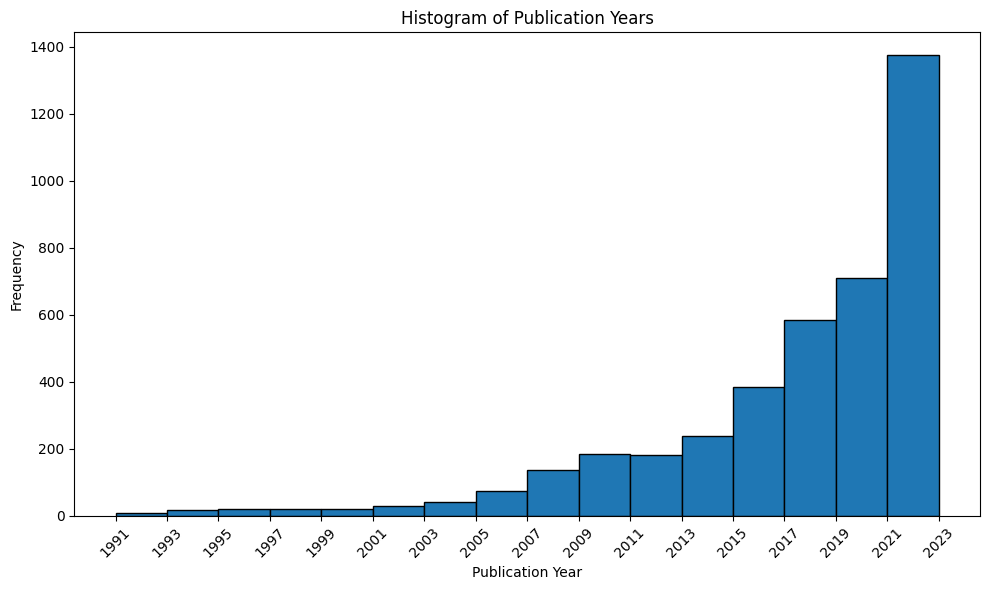

In [7]:
print(dfTot['Publication Year'].min())
print(dfTot['Publication Year'].max())

# Determine the range of years
min_year = dfTot['Publication Year'].min()
max_year = dfTot['Publication Year'].max()

# Set the bin size to 2 years for detailed x-axis labels
bins = range(min_year, max_year + 2, 2)  # Adding 2 to include the last year in the range

# Plot the histogram
plt.figure(figsize=(10, 6))
dfTot['Publication Year'].hist(bins=bins, edgecolor='black')

# Customize the x-axis labels for better detail
plt.xticks(bins, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year')
plt.ylabel('Frequency')
plt.title('Histogram of Publication Years')

# Remove the background grid
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# Number of Journals
len(dfTot['Journal ISO Abbreviation'].unique())

1114

In [9]:
# Author ditribution
clean_authors = dfTot['Authors'].apply(lambda x: re.sub(r'[^\w;]', '', x))

[(a.split(";")) for a in clean_authors]

author_names = []
for a in clean_authors:
  names = a.split(";")
  for name in names:
    author_names.append(name)

authors = pd.DataFrame(pd.Series(author_names).value_counts())
authors

,count
GillP,34
KruglanskiAW,24
FreilichJD,23
ChermakSM,22
RousseauC,20
...,...
DochartaighNO,1
MagniG,1
SgroPM,1
BhattacharyaS,1


## Journals

In [10]:
dfTot.columns[dfTot.columns.str.contains("ournal")]

Index(['Journal Abbreviation', 'Journal ISO Abbreviation'], dtype='object')

In [11]:
def get_journal_info(article_name):
    url = f"https://api.openalex.org/works?search={article_name}"
    response = requests.get(url)
    journal_info = response.json()
    
    # Check if 'results' key is present and has elements
    if 'results' not in journal_info or not journal_info['results']:
        return "", "", ""
    
    # Get the first result
    first_result = journal_info['results'][0]
    
    # Check if 'primary_topic' exists in the first result
    primary_topic = first_result.get('primary_topic')
    if not primary_topic:
        return "", "", ""
    
    # Extract subfield, field, and domain if available
    subfield = journal_info["results"][0]['primary_topic']["subfield"]["display_name"]
    field = journal_info["results"][0]['primary_topic']["field"]["display_name"]
    domain = journal_info["results"][0]['primary_topic']["domain"]["display_name"]
    return subfield, field, domain

In [12]:
df_j = dfTot[["record_id", 'Journal ISO Abbreviation', "Title"]].copy(deep=True)

In [13]:
df_j["journals"] = df_j['Journal ISO Abbreviation'].apply(lambda x : re.sub("[.]", "[a-z]*", str(x)))

In [14]:
#j_data = df_j["Title"].apply(get_journal_info)

In [15]:
#df_j["Subfield"] = [a[0] for a in j_data]
#df_j["Field"] = [a[1] for a in j_data]
#df_j["Domain"] = [a[2] for a in j_data]
#df_j

In [16]:
#df_j.to_json("RTMR_Output/journal_data.json")

# Preprocessing

**Pipeline**:

`data` --> `cleaning` --> `exclusion filter (stopwords, countries, exclusion terms)` --> `classification and replacement` --> `clean_data` --> `nounbydoc` --> *transfer to R* --> `negative binomial` --> `topic modelling` --> `frequence analysis` --> `co-occurrence analysis` --> *transfer to Python* --> `co-occurrence network map`

In [17]:
data = dfTot[["record_id","Author Keywords"]].copy()
data.rename(columns={'Author Keywords': 'keywords'}, inplace=True)

In [18]:
data = data.dropna(subset = ['keywords'])

In [56]:
len(data)

3093

### 1. Cleaning

In [19]:
# Exclude NaNs
data = data.dropna(subset = ['keywords'])

# lower case, replace "-" with space, and split keywords
data.keywords = data.keywords.apply(lambda x: x.replace("-"," ").split("; "))
data.keywords = data.keywords.apply(lambda x: [str(item).lower() for item in x])
#data

In [20]:
print(f"Total number of keywords: {len(data.keywords.sum())}")
print(f"Number of unique keywords: {len(set(data.keywords.sum()))}")


Total number of keywords: 16751
Number of unique keywords: 6608


### 2. Exclusion filter (stopwords, countries, and exclusion terms)

In [21]:
from stop_words import get_stop_words
stoplist = get_stop_words('en')

from country_list import countries_for_language
countries_dict = dict(countries_for_language('en'))
countries_raw = list(countries_dict.values())
countries = [term.lower() for term in countries_raw]

In [22]:
exclusion_list = pd.read_excel("Exclusion_def.xlsx")
excl_list = list(exclusion_list.Exclusion)
excl_list = [str(item) for item in excl_list]
region_list = ['africa','asia','europe','america','middle east',
               "western europe", "northern ireland", "hong kong", "basque country",
               "eastern europe", "southeast asia", "south asia", "somali", "britain", "latin america", "central asia",
               "palestine", 'middle east and north africa']

In [23]:
exclusion_filter = set(excl_list + countries + stoplist + region_list)

*Apply exclusion filter*

In [24]:
data.keywords = data.keywords.apply(lambda x: [item for item in x if item not in exclusion_filter])
#data                                   

In [25]:
print(f"Total number of keywords after exclusion: {len(data.keywords.sum())}")
print(f"Number of unique keywords after exclusion: {len(set(data.keywords.sum()))}")

Total number of keywords after exclusion: 14702
Number of unique keywords after exclusion: 5728


### 3. Term Classification and Replacement (TMSR dictionary.py)

In [26]:
from TMSR_dictionary import word_dict
from Word_functions.word_functions_py import classification, extend_keywords, to_nounbydoc

In [27]:
#keywords_list = sum(data.keywords, [])

In [28]:
#count_dict, uniques, terms_in_cat_dict = classification(keywords_list,word_dict)

In [29]:
#sorted(count_dict.items(), key=lambda item: item[1], reverse = True)

In [30]:
#print(f"{len(uniques)} not classified keywords, with {len(set(uniques))} unique terms.")

In [31]:
from collections import Counter
 
#frequency = Counter(uniques)
#print(frequency)

In [32]:
clean_data = data.copy(deep = True)
clean_data["cat_keywords"] = clean_data.keywords.apply(lambda x: extend_keywords(x,word_dict))
clean_data

,record_id,keywords,cat_keywords
0,50129,"[goal shielding, passion, radicalization, sign...","[passion, radicalism, goal shielding, signific..."
1,2624,"[suicide attacks, extremism, radicalization, r...","[radicalism, fundamentalism]"
2,35510,"[social neuroscience, political neuroscience, ...","[radicalism, group process, social neuroscienc..."
5,728,"[uncertainty identity theory, social identity,...","[identity, radicalism, autocratic leadership, ..."
7,43755,"[ideological extremism, homegrown terrorism, l...","[radicalism, violence, significance quest]"
...,...,...,...
4012,18353,"[institutional logics, microfoundations, polit...","[microfoundations, radicalism, institutional l..."
4013,2048,"[power, islam, muslim clergy, radical islam ex...","[superiority, radicalism, muslim clergy, relig..."
4014,24073,"[right wing extremism, fascism, women, golden ...","[far right, golden dawn, radicalism, nationali..."
4016,50382,"[goal setting, goal formation, personality, so...","[goal setting, social attitudes, goal formatio..."


In [33]:
clean_data.to_json("RTMR_Output/clean_data_study1.json", index = False)

In [34]:
print(f"Total number of keywords after classification: {len(clean_data.cat_keywords.sum())}")
print(f"Number of unique keywords after classification: {len(set(clean_data.cat_keywords.sum()))}")

Total number of keywords after classification: 13469
Number of unique keywords after classification: 3124


### 4. Nounbydoc

Prepare data for van Lissa's code in R (negative binomial, topic modelling, cooccurrences)

In [35]:
nounbydoc = to_nounbydoc(clean_data, "cat_keywords")
nounbydoc

,doc_id,term,freq
0,50129,passion,1
1,50129,radicalism,1
2,50129,goal shielding,1
3,50129,significance quest,1
4,2624,radicalism,1
...,...,...,...
13464,50382,personality,1
13465,2188,pai teaching materials,1
13466,2188,students,1
13467,2188,school,1


In [37]:
nounbydoc.to_csv(r"RTMR_Output/nounbydoc_study1.csv", index = False)

In [52]:
frequency = Counter(nounbydoc.term)
one_hit_wonders = [term for term, n in frequency.items() if n == 1]
print("Number of terms occurring only once: ", len(one_hit_wonders))

Number of terms occurring only once:  2451


===========================================================================================================================

### Run R script for:
* Negative Binomial (Pruning)
* Word Frequency
* Topic Modelling
* Term co-occurrences

##### using van Lissa's R code
  
===========================================================================================================================

In [53]:
os.chdir("Word_functions")
r_script_path = 'Keywords_RTMR_.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


## I. Word Frequency

In [39]:
freq_df = pd.read_csv(r"RTMR_Output/Keywords_freq_study1.csv").sort_values(by= "Frequency", ascending=False).reset_index()
len(freq_df)

81

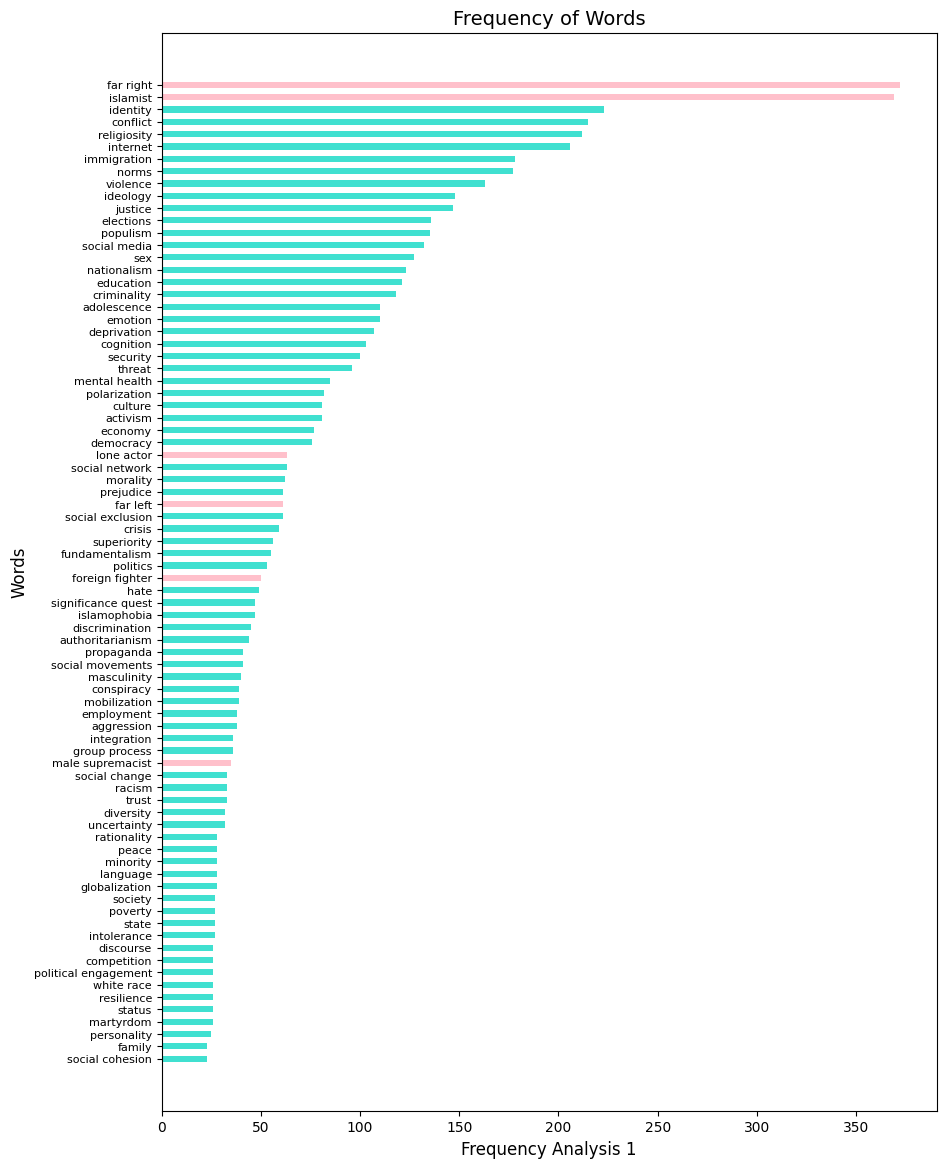

In [40]:
plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)
highlight_words = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]
colors = ['turquoise' if word not in highlight_words else 'pink' for word in plt_df['Word']]

plt.figure(figsize=(10,14))
plt.barh(plt_df['Word'], plt_df['Frequency'], color=colors, height = 0.5)

plt.xlabel('Frequency Analysis 1', fontsize=12)  
plt.ylabel('Words', fontsize=12)
plt.title('Frequency of Words', fontsize=14)

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/keywordsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


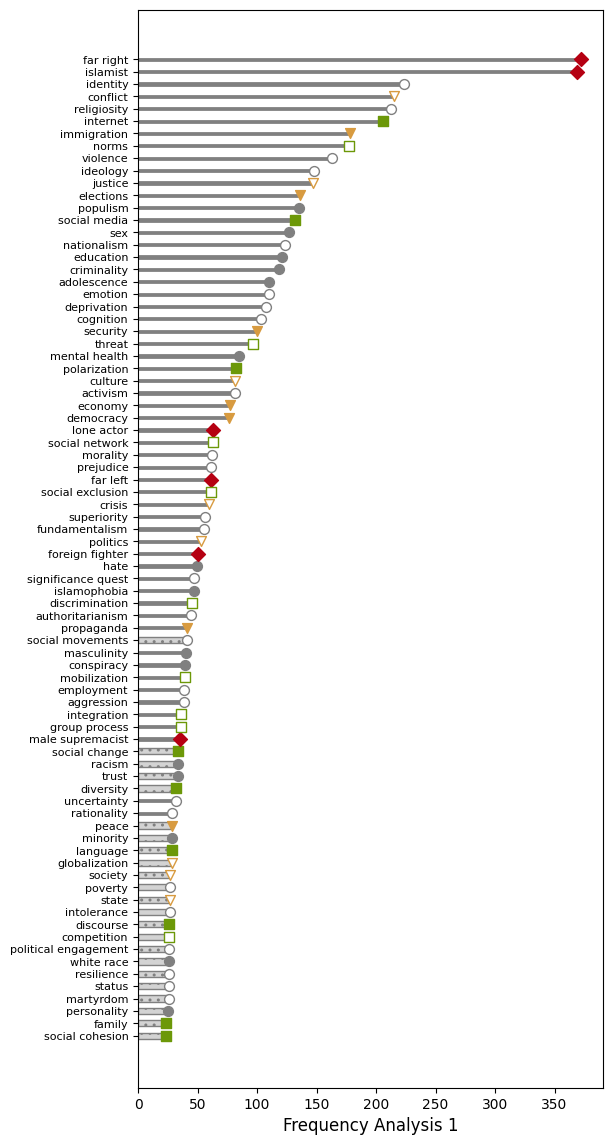

In [41]:
import matplotlib.pyplot as plt

# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt.figure(figsize=(6, 14))  # Adjusted figure size to make it more narrow

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 1', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/keywordsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


## Graph with categories

In [42]:
import networkx as nx

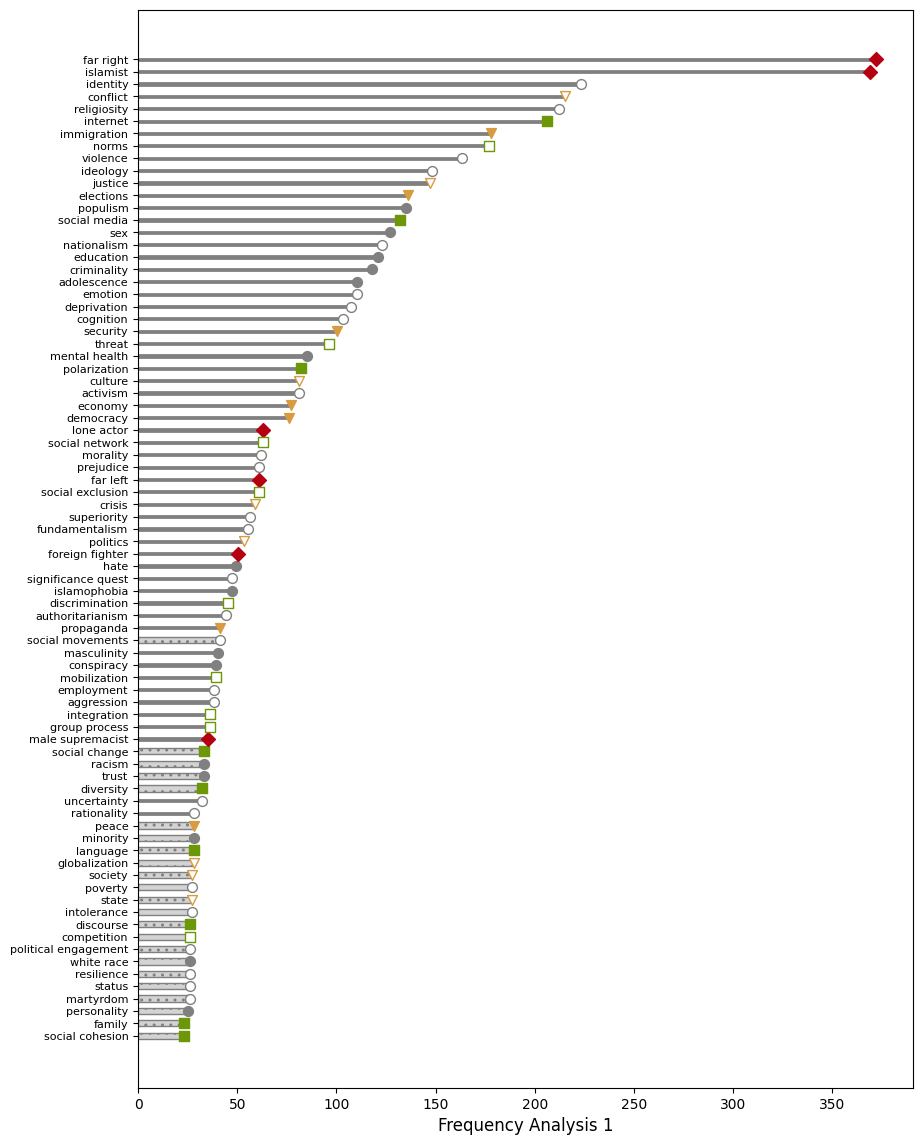

In [43]:
import matplotlib.pyplot as plt

# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt.figure(figsize=(10, 14))

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 1', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/keywordsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


## II. Co-occurrences

In [44]:
import networkx as nx

In [45]:
cooc_df_incl = pd.read_csv(r"RTMR_Output/Keywords_cooc_inclrad_study1.csv")
cooc_df_excl = pd.read_csv(r"RTMR_Output/Keywords_cooc_worad_study1.csv")
cooc_df_ado = pd.read_csv(r"RTMR_Output/Keywords_cooc_adolescence_study1.csv")
cooc_df_islamist = pd.read_csv(r"RTMR_Output/Keywords_cooc_islamist_study1.csv")
cooc_df_right = pd.read_csv(r"RTMR_Output/Keywords_cooc_far-right_study1.csv")
cooc_df_left = pd.read_csv(r"RTMR_Output/Keywords_cooc_far-left_study1.csv")
cooc_df_lone = pd.read_csv(r"RTMR_Output/Keywords_cooc_lone-actor_study1.csv")

In [46]:
cooc_df_incl

,term1,term2,cooc,id
0,radicalism,islamist,285,islamistradicalism
1,radicalism,far right,271,far rightradicalism
2,radicalism,internet,170,internetradicalism
3,radicalism,identity,166,identityradicalism
4,religiosity,radicalism,145,radicalismreligiosity
...,...,...,...,...
62,radicalism,conspiracy,26,conspiracyradicalism
63,radicalism,employment,26,employmentradicalism
64,radicalism,masculinity,26,masculinityradicalism
65,uncertainty,radicalism,26,radicalismuncertainty


In [55]:
print("Edges: ", len(cooc_df_incl))
print("Nodes: ", len(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))
print("Min number of co-occurrences: ", cooc_df_incl.cooc.min())


Edges:  67
Nodes:  58
Min number of co-occurrences:  26


### Network Visualisation

#### a) With "radicalism"

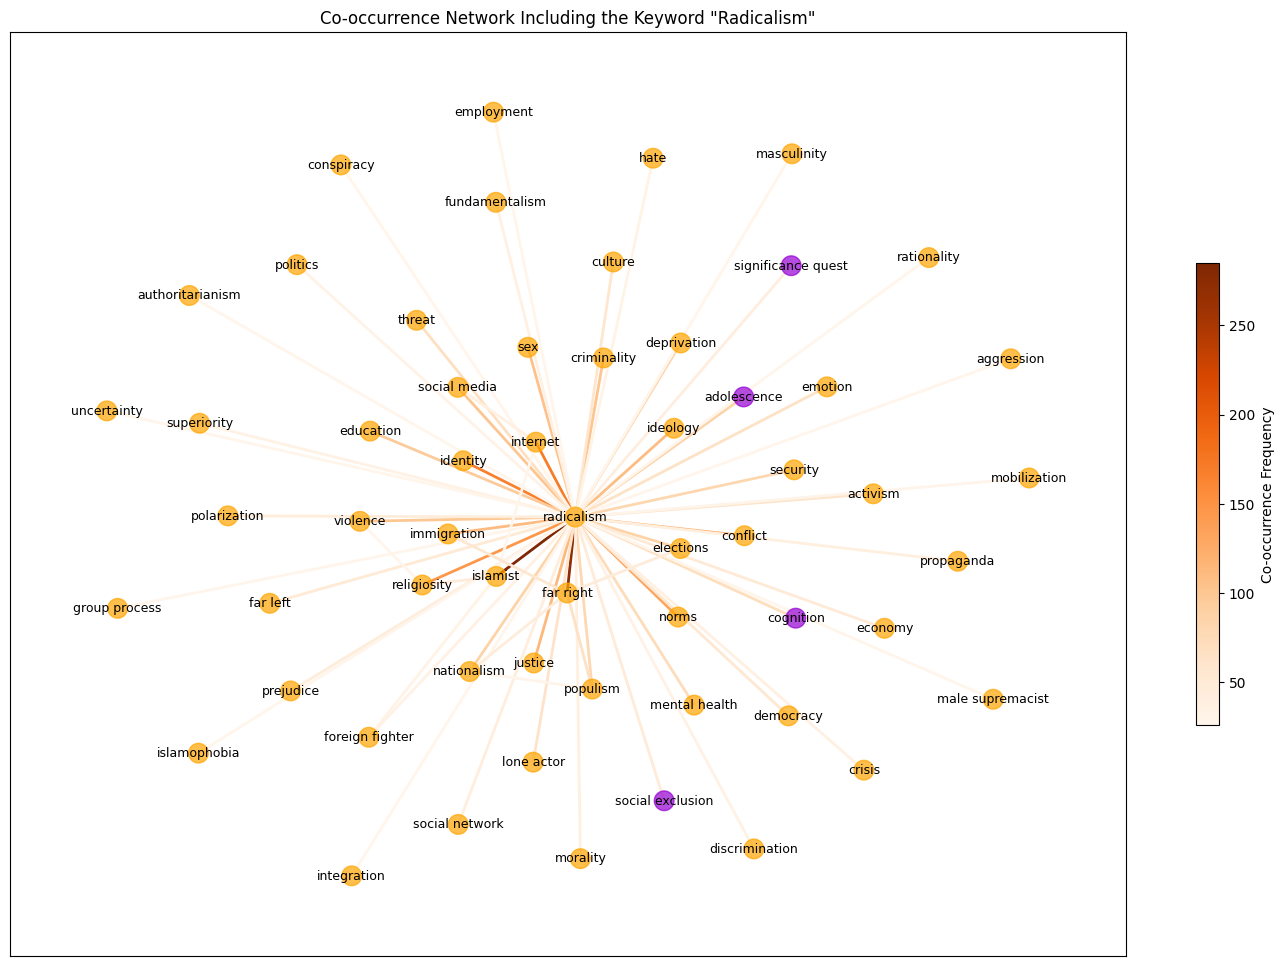

In [48]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_incl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['adolescence', "cognition", "significance quest", "social exclusion"]
colors = ['orange' if node not in highlight_nodes else 'darkviolet' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width = 2, #width=[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network Including the Keyword "Radicalism"')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### Experimenting with graph

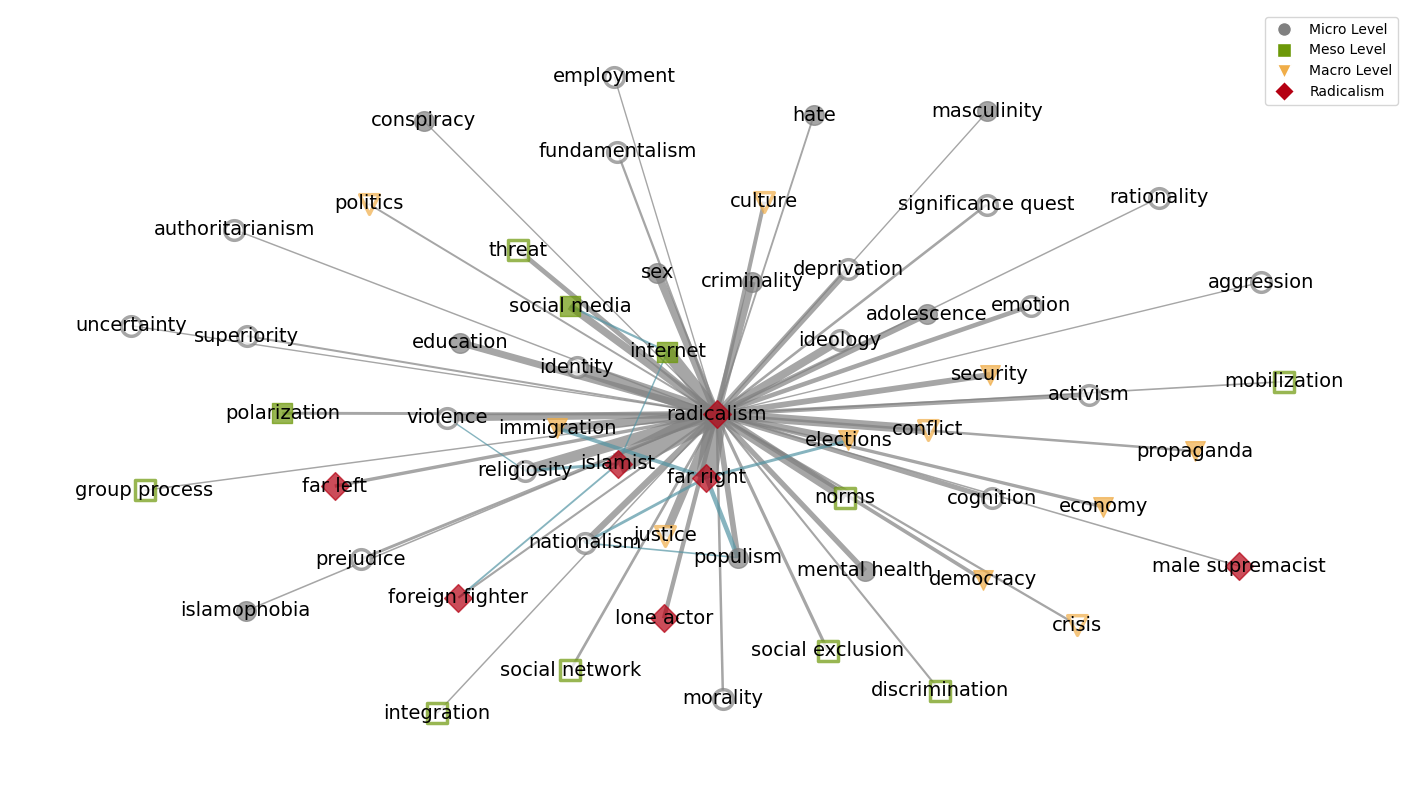

In [49]:
import matplotlib.pyplot as plt
import networkx as nx

# Define terms for each category based on your categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change",
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience"
]

radicalism_nodes = ["radicalism", "far right", "islamist", "far left", "foreign fighter", "lone actor", "male supremacist"]

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_incl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors: grey if connected to radicalism, otherwise black
edge_colors = ['grey' if 'radicalism' in (u, v) else '#5495a4' for u, v in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/keywords_cooccurence_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()


#### b) Without "radicalism"

In [50]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_excl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['adolescence'] + list(G.neighbors("adolescence"))
colors = ['orange' if node not in highlight_nodes else 'darkviolet' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.5)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network Excluding the Keyword "Radicalism"')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

NetworkXError: The node adolescence is not in the graph.

<Figure size 1800x1200 with 0 Axes>

#### c) Centred around "adolescence"

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_ado.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['adolescence']
colors = ['orange' if node not in highlight_nodes else 'red' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network for Adolescence')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### d) Centred around "islamist"

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_islamist.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['islamist']
colors = ['orange' if node not in highlight_nodes else 'red' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network for Islamist')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### e) Centred around "far right"

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_right.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['far right']
colors = ['orange' if node not in highlight_nodes else 'red' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network for Far Right')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### f) Centred around "far left"

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_left.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['far left']
colors = ['orange' if node not in highlight_nodes else 'red' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network for Adolescence')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### g) Centred around "lone actor"

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_lone.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
highlight_nodes = ['lone actor']
colors = ['orange' if node not in highlight_nodes else 'red' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.7)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network for lone actor')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

## Terms not occurring in cooccurrence

In [ ]:
print("Terms not occurring in co-occurrnece maps: \n", set(list(freq_df.Word)).difference(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))

## Chi square analysis of within vs. between category co-occurrences

In [ ]:
data_chi = cooc_df_excl.copy(deep=True)
data_chi

In [ ]:
# Define terms for each category based on your updated categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "immigration", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority", "fusion",
    "masculinity", "racism"
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "discourse", 
    "family", "competition", "polarization", "discrimination", "group process", 
    "recruitment", "elites", "social media", "social coherence", "mobilization", 
    "integration", "social movements"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", "norms", 
    "culture", "internet", "security", "region", "elections", "policy", "democracy", 
    "language", "international", "crisis", "institutions", "peace", "propaganda", 
    "military"
]

# Function to categorize terms
def categorize_terms(term):
    if term in micro_terms:
        return 'micro'
    elif term in meso_terms:
        return 'meso'
    elif term in macro_terms:
        return 'macro'
    else:
        return 'unknown'

In [ ]:
# Apply categorization to terms
data_chi['category1'] = data_chi['term1'].apply(categorize_terms)
data_chi['category2'] = data_chi['term2'].apply(categorize_terms)

# Filter out unknown categories
cooc_df_filtered = data_chi[(data_chi['category1'] != 'unknown') & (data_chi['category2'] != 'unknown')]
cooc_df_filtered

In [ ]:
data_chi[ (data_chi.category2 == "unknown") | (data_chi.category1 == "unknown") ]

In [ ]:
## how often do the levels occurr
freq_levels = Counter(list(cooc_df_filtered.category1) + list(cooc_df_filtered.category2))
total_nodes = np.sum(list(freq_levels.values()))
for key, value in freq_levels.items():
    freq_levels[key] = value / total_nodes
freq_levels

In [ ]:
n = cooc_df_filtered.cooc.sum()
n

In [ ]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

In [ ]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

In [ ]:
from scipy.stats import chi2_contingency

# Observed counts
observed = [[occ_within, n - occ_within], [occ_between, n - occ_between]]

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

print(f"Chi2: {np.round(chi2,2)}, p-value: {np.round(p,3)}")

In [ ]:
print(f"Contingency Table:\n\n   within between\nyes {np.array(observed)[0]}\nno  {np.array(observed)[1]}")

In [ ]:
from scipy.stats import binom_test
print(binom_test(x=occ_between, n= n, p=1/2))
print(binom_test(x=occ_within, n= n, p=1/2))
